<a id="top"></a>
# WFC3/UVIS Spatial Scan Sensitivity Monitor
***
## Learning Goals
This notebook shows how to perform aperture photometry on calibrated (FLT) WFC3/UVIS spatial scan observations in order to monitor detector stability over time.

By the end of this tutorial, you will:

- Locate and download new spatial scan observations from MAST.
- Verify data quality of spatial scans, discarding any compromised exposures.
- Remove cosmic rays from exposures and perform aperture photometry on the spatial scans.
- Produce intermediate photometry catalogs for each target and filter.
- Clip and normalize data to produce plots.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Pipeline](#pipeline) <br>
- [2.1 Setup](#setup) <br>
- [2.2 New Data (optional)](#newdata) <br>
    - [2.2.1 Download New Data](#download) <br>
    - [2.2.2 Data Quality Verification](#dq) <br>
    - [2.2.3 Review and Exclude](#move) <br>
- [2.3 Photometry](#photometry) <br>

[3. Analysis](#analysis) <br>
- [3.1 Construct Catalog](#catalog) <br>
- [3.2 Plot Percent Countrate Change as a Function of Time ](#percentchange) <br>
- [3.3 Plot Sensitivity as a Function of Filter/Wavelength](#filterpivot) <br>

[4. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>

The spatial scan observation mode for the WFC3/UVIS detector was introduced in 2011 during [Cycle 19](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2012/WFC3-2012-04.pdf) as an alternative to the default staring mode. 

As detailed in [ISR 2017-21](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-21.pdf) and [ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf), spatial scans have higher signal-to-noise in comparison to staring mode observations. In scan mode, the telescope moves in a defined path, either scanning in one straight line or in muliple reciprocating, or "boustrophedonic", lines (explained more fully in [ISR 2017-06](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-06.pdf)). Photons from sources observed in scan mode are therefore distributed across a greater number of pixels on the detector. Not only does this enable longer exposures of bright objects before saturating the detector, but the greater number of photons able to be captured in scan mode significantly reduces both the Poisson noise and the impact of spatial effects, producing higher precision photometry. 

This notebook extends the Python reduction pipeline introduced in [ISR 2017-15](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-15.pdf) and summarized in [ISR 2021-04](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf) Section 2.1, leveraging the interactive notebook format as a user-friendly tool for investigation. 

Our purpose here is to monitor the temporal photometric stability of the UVIS detector. 

## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library Internal's](https://github.com/spacetelescope/WFC3Library_internal) installation instructions.

For this notebook, we directly import: 

- *os* for setting environment variables
- *glob* for finding lists of files
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating/managing tables of data 
- *warnings* for ignoring known deprecation warnings.

Under the hood, functions from `WFC3_phot_tools` and `pyql` are called. Installation instructions for these two libraries are in this notebook's `README.md` file. 

Finally, we import three scripts created specifically for this monitor, as well as a handful of global variables. 

In [ ]:
import os
import glob
import numpy as np

from astropy.io import fits
from astropy.table import Table
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

import UVIS_scan_monitor_utilities as scan_utils
import UVIS_scan_monitor_plotting as scan_plot
import UVIS_scan_monitor_pipeline as scan_pipeline

from UVIS_scan_monitor_pipeline import DATA_DIR, TS, LOG_FILE, LOG_DIR, FLAGS_DEF, PARAMS_DEF

## 2. Pipeline <a id="pipeline"></a>

The function `scan_pipeline.main_process_scan_UVIS()` can download new files from the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/), enable data quality verification by manual inspection, perform cosmic ray rejection, reprocess previously processed data, and perform aperture photometry on the files. Which steps of the pipeline are executed, and how, must be set by the user within the `flags` and `params` arguments. 

- `flags` is a dictionary of Boolean execution flags, which determine whether a certain step of the process is run.

- `params` is a dictionary of pipeline parameters. 

The contents of these dictionaries are defined below.

#### Flags <a id="defineflags"></a>
----------

- **`newdat`**: If True, new data  from the specified proposals will be downloaded. If False, no new data will be downloaded.
- **`sortdat`**: If True, downloaded data will be sorted for quality. If False, sorting will not occur. 
- **`crrej`**: If True, run cosmic ray (CR) rejection on new input files, which have been sorted for quality. If False, do not run CR rejection. 
  - This part of the pipeline takes a significant amount of time.
- **`crrepr`**: If True, run all data through cosmic ray (CR) rejection process, including previously processed data. If False, do not. 
  - Do not use unless you genuinely want to redo all of the cosmic ray rejection that has already been done on files in the `data` directory.
- **`run_apphot`**: If True, run aperture photometry on all data in the `data` directory, and save photometry catalogs to the `output` directory. If False, do not.
  - This will overwrite any photometry catalogs currently in the `output` directory.
- **`show_ap`**: If True, plot each aperture in line as you run aperture photometry on input data. If False, do not. 
  - If `show_ap` is True, then `run_apphot` should also be set to True. 


#### Parameters <a id="defineparams"></a>
---------------

- **`prop_ids`** : *(type = list of integers)*: a list of proposal IDs to be used when downloading data.
  - Note: It is recommended to only have one proposal ID in use for the data download/quality verification step.
- **`proc_objs`** *(type = string or list of strings)*: identifier for object name(s) in the downloaded data to be processed. 
  - Default is 'all'.
  - Other options include: 'GD153', \['GD153, 'GRW70'\].
- **`proc_filts`** *(type = string or list of strings)*: identifier for filter name(s) in the downloaded data to be processed.
  - Default is 'all'.
  - Other options include 'F606W', \['F606W', 'F483W'\], etc.
- **`file_type`** *(type = string)*: input file type to be processed.
  - Default is 'flt'.
  - Other options include 'flc', 'raw', etc.
- **`ap_dim`** *(type = tuple of integers)*: desired aperture dimensions (x dimension, y dimension) to use for aperture photometry. 
  - Default is (36, 240).
- **`sky_ap_dim`** *(type = tuple of integers)*: desired sky aperture dimensions (x dimension, y dimension) to use for aperture photometry.
  - Default is (75, 350).
- **`back_method`** *(type = string)*: background determination method.
  - Default is 'mean'.
  - Alternate option is 'median'.
- **`ncores`** *(type = integer)*: number of processor cores to use for multiprocessing.
  - Default is 20.
- **`ap_phot_file_type`** *(type = string)*: file type for aperture photometry, determined programmatically based on the value of the **`crrej`** flag.
  - Note: If you update `crrej`, you must update `ap_phot_file_type`.


### 2.1 Pipeline Setup <a id="setup"></a>

Upon importing `UVIS_scan_monitor_pipeline.py`, the default versions of these dictionaries are defined as global variables `FLAGS_DEF` and `PARAMS_DEF`. Run the following cell to set up the default variables. We will update them later.

In [ ]:
flags = FLAGS_DEF
params = PARAMS_DEF

if flags['crrej']:
    params['ap_phot_file_type'] = 'fcr'
else:
    params['ap_phot_file_type'] = params['file_type']

Run the following two cells to see the values of the constructed dictionaries.

In [ ]:
flags

In [ ]:
params

### 2.2 New Data (Optional)<a id="newdata"></a>

If you wish to download data from MAST, the flag `newdat` should be switched on, and the parameter `proposid` must be updated. By default, calibrated exposures will be downloaded (`params['file_type']='flt'`).


#### 2.2.1 Download New Data <a id="download"></a>

Adjust/update flags and parameters as needed, and then run the following cell.

Review definitions for [`flags`](#defineflags) and [`params`](#defineparams) if needed.

In [ ]:
flags['newdat'] = True
params['prop_ids'] = [15398]
params['proc_objs'] = 'GD153'
params['proc_filts'] = 'F814W'

In [ ]:
params

Now we can download our data. Run the following cell to download data from the proposal.

In [ ]:
scan_pipeline.main_process_scan_UVIS(flags, params)

#### 2.2.2 Data Quality Verification <a id="dq"></a>

Before we perform any photometry, we must identify compromised exposures and remove them from our files to be processed. 

To do so, we will manually sort through the newly downloaded files and identify which ones are bad or compromised. Then we will move the flagged exposures to the `bad` directory.

We start by creating a list of all fits files in the `new` directory. Then, we manually examine each exposure. The spatial scan of each white dwarf should appear as a relatively bright, vertical line centered on the subaray, without significant pertubations to the line (wiggles, curves, discontinuities, etc.). We should reject the exposure if there is no vertical line.

Each exposure will be displayed in three plots and shown inline, and will be followed by a user prompt to keep or reject the file. 
- Plot 1 shows the entirety of the exposure with a gray colormap (bright sources are dark against a light background). A rectangle is drawn indicating the sky aperture dimensions defined in `params['sky_ap_dim']`.
- Plot 2 is the same as Plot 1, but the colormap is inverted (bright sources are light against a dark background) and the data is normalized with the lower and upper limits set to 50% and 95% percentile, to mimic the "99.5%" scale setting in SAOImage DS9. 
- Plot 3 only shows the extent of the exposure captured by the `params['sky_ap_dim']` setting, and uses a log normalization on the data. A colorbar is shown to the right. 

Manually flagging the exposures builds a list of files (`bad_list`) that will be removed from the `new` directory before aperture photometry is performed.

##### Example 1 - missing source

Sometimes it may be hard to see the scan in Plot 1 because it may be faint. But in the following exposure, there is no source to be found even with adjusting the scale threshold in Plot 2 or log normalizing the data in Plot 3. There's nothing to perform photometry on here, so we'll reject this exposure.

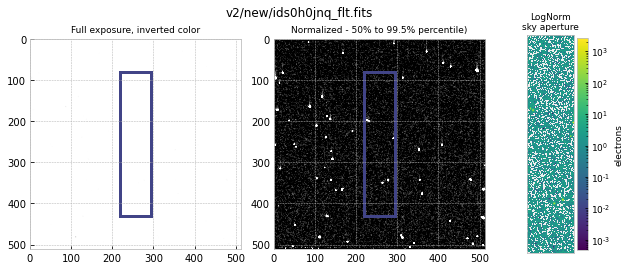

##### Example 2 - non-linear scan

During observations, the telescope should only be moving in one direction, to enable a vertical spatial scan. If the telescope has not properly locked onto guide stars and drifts or adjusts mid-spatial scan, the scan will not be linear and/or vertical (resulting in curves, wiggles, crooked, or slanted scans). This makes aperture photometry very difficult, so we will reject exposures like the following.

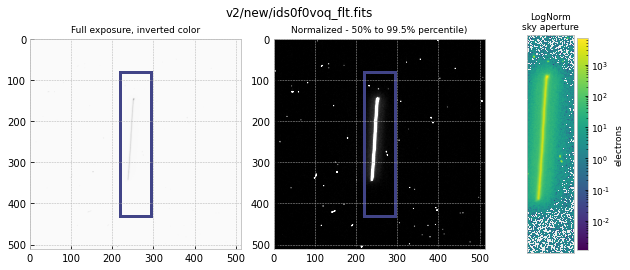

##### Example 3 - a good scan

The following exposure is an example of a usable spatial scan. The line from the dwarf star being scanned is solid and straight. We can perform aperture photometry on this source. 

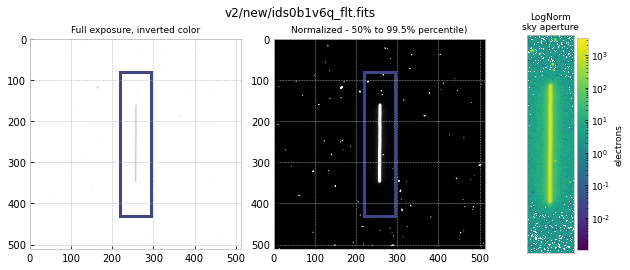

Run this cell to visually inspect newly-downloaded exposures.

In [ ]:
fits_list = glob.glob(f'{DATA_DIR}new/*.fits')
bad_list = []
scan_utils.inspect_exposures(fits_list, bad_list, params=params, save_figs=False)


#### 2.2.3 Review and exclude <a id="move"></a>

You can also revise the list of flagged files before you remove them from the processing pipeline. There are two different ways you can do this, and both are optional.

The function `review_bad()` allows you to re-examine all flagged exposures in case any were flagged by mistake.

The function `review_good` allows you to re-examine all un-flagged exposures, in case you didn't flag a file that should be removed.

Both functions update the list `bad_list` that will then be used to remove all flagged exposures.

In [ ]:
#bad_list = scan_utils.review_bad(bad_list, params=params)

In [ ]:
#bad_list = scan_utils.review_good(fits_list, bad_list, params)

Once you are satisfied that you have accurately flagged all exposures, run the following cell to move the flagged exposures from the `new` directory into the `bad` directory. This will also add the names of the removed files to the `LOG_FILE`. 

In [ ]:
scan_utils.move_bad_data(bad_list, DATA_DIR, LOG_FILE)

### 2.3 Photometry <a id="photometry"></a>

Perform aperture photometry on validated exposures, and format the output data tables.

To run the pipeline in photometry mode, we'll need to make sure we have the flags and parameters properly set.

Review definitions for [`flags`](#defineflags) and [`params`](#defineparams) if needed.

Adjust the following cells as needed, and run. 

In [ ]:
flags['newdat'] = False
flags['sortdat'] = False
flags['crrej'] = False
flags['run_apphot'] = True

flags

In [ ]:
params['sky_ap_dim'] = (300, 400)

if flags['crrej']:
    params['ap_phot_file_type'] = 'fcr'
else:
    params['ap_phot_file_type'] = params['file_type']
    
params

Once you've verified that your flags and parameters are correctly set, run the following cell. It may take a while. For one proposal, two objects, seven filters, and all execution flags turned on (besides `newdat`), runtime is approximately 2 hours. 

In [ ]:
scan_pipeline.main_process_scan_UVIS(flags, params)

## 3. Analysis <a id="analysis"></a>


### 3.1 Construct Catalog <a id="catalog"></a>

If the pipeline is run with the aperture photometry flag switched on, output photometry table(s) are generated from all fits files located in the `data` directory, and are saved in the `output` directory. 

We are going to create one large data table (representing this run of the pipeline) by stacking together all photometry catalogs generated in the previous step and currently located in the `output` directory.

As an optional parameter, we can copy the output catalogs to the log directory for this pipeline run (`LOG_DIR`), since subsequent runs of the pipeline will overwrite the photometry catalogs in `output`.

In [ ]:
data_list = glob.glob(f'{DATA_DIR}output/*.dat')

all_data = scan_utils.aggregate_data(data_list, LOG_FILE, archive=False, log_dir=LOG_DIR)

For now, we are also going to ignore results from star P330E.

In [ ]:
clip_data = all_data[all_data['targname'] != 'P330E']

We can define our main filters and targets.

In [ ]:
filters = ['F218W', 'F225W', 'F275W', 'F336W', 'F438W', 'F606W', 'F814W']
targets = ['GD153', 'GRW70']

Now, we'll remove outliers from our data and normalize data. 

For each filter/target/chip data subset, outliers are calculated by the following process:
- A slope is fit to the entire data subset (time versus countrate) using linear regression.
- Residuals are calculated by subtracting the expected countrate from the actual measured countrate at each time.
- Sigma clipping is performed using the `astropy.stats.sigma_clip()` function, iterating 5 times over the data and identifying values that are more than 2.5 standard deviations from the median of the subset. 
- Outlier data is stored in the `all_outliers` Astropy table.

Remaining data is then normalized within each filter/target/chip subset through the following process:
- Using data from the earliest proposal within the data set, a mean is calculated.
- All data points within the subset are then divided by that mean.
- To calculate the percent change in comparison to the normalized value, 1 is subtracted from this ratio, and the difference is multiplied by 100.

In [ ]:
clean_table, all_outliers = scan_plot.clean_data(clip_data, filters, targets,
                                                 show_residuals=True, save_residuals=True)


How much data are we throwing away with the outliers?

In [ ]:
percent = len(all_outliers)/(len(clip_data)+len(all_outliers)) * 100
print ('We are removing {:.3f}% of observations from the clipped data.'.format(percent))

### 3.2 Plot Percent Countrate Change as a Function of Time <a id="percentchange"></a>

Here, we'll make one plot per filter in `filters`, with each plot containing two subplots corresponding to the two UVIS chips. Line of best fit for each filter/chip/target configuration will be plotted, as well as an overall line of best fit.

For each filter/chip configuration, the following steps are taken:
- Data is further divided by target. 
- Using linear regression, slope and slope error is calculated for each target subset. 
- Individual data points for each target are plotted, as well as a line of best fit.
- A final line of best fit is calculated using linear regression of the data from all targets within the filter/chip subset. 


In [ ]:
scan_plot.plot_cr_by_filter(clean_table, filters,
                            show_plots=True, save_plots=True)

We can also plot all of the data per chip together.

In [ ]:
scan_plot.plot_cr_all_filters(clean_table, filters,
                              show_plots=True, save_plots=True)

### 3.3 Plot Sensitivity as a Function of Filter/Wavelength <a id="filterpivot"></a>

To more closely look at the rate of change, we can also plot the overall slope of the data (the declining chip sensitivity) in comparison to the filter or wavelength. For simplicity's sake, we make a table with all the slope information:

In [ ]:
slope_tbl, year_span = scan_plot.make_slope_table(clean_table)

Now, plot slope by filter.

In [ ]:
scan_plot.plot_slope_by_filter(slope_tbl, year_span, save_plot=True)

As an alternative, we can plot slope by pivot wavelength.

In [ ]:
scan_plot.plot_slope_by_pivotwl(slope_tbl, year_span, save_plot=True)

## 4. Conclusions <a id="conclusions"></a>

We can see that the sensitivity of the UVIS detectors is decreasing over time, as expected. This change appears to be most drastic in the bluest filters, but measured sensitivity rate change do appear to be in good agreement with results from the staring mode photometry monitor. Future work may encompass direct comparison to synthetic photometry as an additional component of analysis. 

Thank you for walking through this notebook. Now with WFC3 UVIS spatial scan data, you should be able to:

- Locate and download new spatial scan observations from MAST.
- Verify data quality of spatial scans, discarding any compromised exposures.
- Remove cosmic rays from exposures and perform aperture photometry on the spatial scans.
- Produce intermediate photometry catalogs for each target and filter.
- Clip and normalize data, producing plots.

**Congratulations, you have completed the notebook!**

## Additional Resources <a id="add"></a>

- [ISR 2021-04: New time-dependent WFC3 UVIS inverse sensitivities](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf)
- [ISR 2017-21: Photometric Repeatability of Scanned Imagery: UVIS](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-21.pdf)
- [ISR 2017-15: 2017 Update on the WFC3/UVIS Stability and Contamination Monitor](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-15.pdf)
- [ISR 2017-06: Trajectories of Multi-lined Spatial Scans](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-06.pdf)
- [ISR 2012-08: Considerations for using Spatial Scans with WFC3](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2012/WFC3-2012-08.pdf)

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)


## About this Notebook <a id="about"></a>

**Author:** Mariarosa Marinelli, ISSB/WFC3 

**Updated On:** 2021-10-11


## Citations <a id="cite"></a>

If you use `numpy`, `astropy`, or `matplotlib` for published research, please cite the
authors. Follow these links for more information about citing these libraries. 

* [Citing `numpy`](https://www.scipy.org/citing.html#numpy)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `matplotlib`](https://matplotlib.org/stable/citing.html)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 